<h1 class="alert alert-block alert-info" style="text-align:center; font-size:30px">Daily COVID-19 Interactive Plots</h1>

<h1> What is the COVID-19/Coronavirus? </h1>

* According to the CDC, "Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness."
* Continuing, "The best way to prevent and slow down transmission is to be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face."
* Stay informed about COVID-19. Practice social distancing and healthy practices (washing hands). Educate your friends and family on the dangers of COVID-19. 
* Yes, there's currently a vaccine out, but the vaccine will take quite a while to distribute to everyone. Thus, I encourage everyone reading to be patient about COVID so we can unite together and minimize the catastrophic damage the coronavirus has inflicted.

<h1> Aims of this Project </h1>

* This project aims to show COVID-19 data in a **robust** manner through **easy-to-digest** visualizations, so you can stay aware of the current state of COVID-19 at your fingertips.
* This notebook shows the state of the coronavirus for the **previous** day. It does not look at past/moving trends, like <a href="https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction"> this COVID-19 notebook</a>, but instead visualizes what happened with COVID yesterday.
* To obtain the real-time COVID-19 data, I utilize a small web scraping script and the <a href="https://www.worldometers.info/coronavirus/"> worldometers website</a>. A distinctive advantage of doing so is that the data used in this notebook does **not** have to be updated extraneously; instead, the dataset is crated right here in this notebook.
* This project is very Work in Progress, so if anyone has suggestions or even would like to **code visualizations that are particularly meaningful**, please share them with me so I can improve and/or add new visualizations to this notebook. Feel free to also fork this notebook to play around with the data or just to learn something new.

For more information on COVID-19, please check out this <a href="https://www.who.int/news-room/q-a-detail/coronavirus-disease-covid-19"> World Health Organization FAQ</a>. It is a fantastic resource to educate yourself.

<p style="font-size: 20px"> <b> I will be running this notebook every day</b> until we truly "flatten the curve". </p>

<h2> Table of Contents </h2>

<ol style="font-size: 16px">
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#gather">Gathering the Data</a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#general">General Visualizations </a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#continent">By Continent </a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#countries"> By Country </a> </li>
</ol>

<h2> Starred Visualiztions </h2>
<ol style="font-size: 16px">
    <ul> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#country-search">Interactive Search for Stats by Your Country </a> </ul>
<ol>

# TL;DR, why should I care?

In [1]:
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
from datetime import date, datetime
fname = 'https://www.worldometers.info/coronavirus/'
req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")

In [2]:
today = datetime.now()
now_str = "%s %d, %d at %d:%s" % (date.today().strftime("%b"), today.day, today.year, today.hour, '0'+str(today.minute) if today.minute < 10 else str(today.minute))
containers = page_soup.findAll("div", {"class": "maincounter-number"})
print("As of %s UTC, there have been %s total COVID-19 cases." % (now_str, containers[0].findAll("span")[0].text.replace(' ', '')))

As of Jan 23, 2021 at 15:03 UTC, there have been 99,149,814 total COVID-19 cases.


Hopefully now you think you should care. Crazy numbers, right? Before we get started, please <span style="font-size: 20px; color: green; font-weight: bold"> leave an upvote </span> if you think this notebook is a valuable resource. I would love if this could become a community project, and upvoting helps with the publicity. Anyways, now, without further ado, let's get started!

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="gather">Gathering the Data (Web Scraping)<a class="anchor-link" href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#gather">¶</a></h1>

<h1> Essential Imports </h1>

In [3]:
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import gc #garbage collector
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns

<h1> Web Scraping Foundation </h1>

In [4]:
fname = 'https://www.worldometers.info/coronavirus/#countries'
req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")
today = datetime.now()
today_str = "%s %d, %d" % (date.today().strftime("%b"), today.day, today.year)
yesterday_str = "%s %d, %d" % (date.today().strftime("%b"), today.day-1, today.year)
clean = True

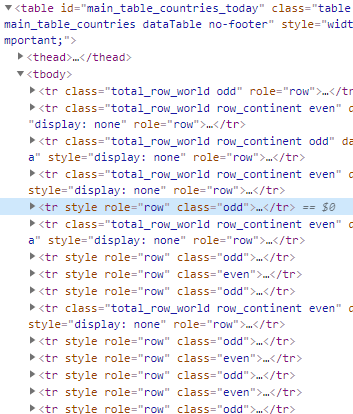
> Screenshot of HTML for the website we are scraping.

In [5]:
print("This version of the notebook is being run on %s." % today_str)

This version of the notebook is being run on Jan 23, 2021.


<h1> Scraping Script </h1>

If clean is set to <span style="color: blue"> true</span>, then the numerical data will be converted from a string to a float. We drop China in our analysis because of some inconsistent positioning for China when scraping the data.

In [6]:
table = page_soup.findAll("table", {"id": "main_table_countries_yesterday"})
containers = table[0].findAll("tr", {"style": ""})
del containers[0]

all_data = []
for country in containers:
    country_data = []
    country_container = country.findAll("td")
    if country_container[1].text == 'China':
        continue
    for i in range(1, len(country_container)):
        final_feature = country_container[i].text
        if clean:
            if i != 1 and i != len(country_container)-1:
                final_feature = final_feature.replace(',', '')
                if final_feature.find('+') != -1:
                    final_feature = final_feature.replace('+', '')
                    final_feature = float(final_feature)
                elif final_feature.find('-') != -1:
                    final_feature = final_feature.replace('-', '')
                    final_feature = float(final_feature)*-1
        if final_feature == 'N/A':
            final_feature = 0
        elif final_feature == '' or final_feature == ' ':
            final_feature = -1 #None
        country_data.append(final_feature)
    all_data.append(country_data)

In [7]:
df = pd.DataFrame(all_data)
df = df.drop([15, 16, 17], axis=1) # Get rid of unnecessary data

On the <a href="https://www.worldometers.info/coronavirus/"> worldometers website</a>, the category "New Recovered" doesn't appear; however, based on the numbers, we can interpolate a certain column of data to be that.

In [8]:
column_labels = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Serious/Critical",
                "Tot Cases/1M", "Deaths/1M", "Total Tests", "Tests/1M", "Population", "Continent"]
df.columns = column_labels

<h1> What Countries are not present in the Analysis? </h1>

For some reason, there are some countries that are not included when scraping the webpage.

In [9]:
country_labels = page_soup.findAll("a", {"class": "mt_a"})
c_label = []
for country in country_labels:
    c_label.append(country.text)
c_label = set(c_label)

not_counted = []
sorted_countries = set(df['Country']) #Increase computational speed
for country in c_label:
    if country not in sorted_countries:
        not_counted.append(country)

In [10]:
print(not_counted + ['China'])

['Samoa', 'Vanuatu', 'Saint Pierre Miquelon', 'Fiji', 'Laos', 'Anguilla', 'Marshall Islands', 'Wallis and Futuna', 'China', 'Tajikistan', 'Montserrat', 'Greenland', 'China']


<h1> Final Processing </h1>

Here, we will convert all the numerical data into np.int64 data type, and add some other features that may be particularly useful.

In [11]:
for label in df.columns:
    if label != 'Country' and label != 'Continent':
        df[label] = pd.to_numeric(df[label])

In [12]:
df['%Inc Cases'] = df['New Cases']/df['Total Cases']*100
df['%Inc Deaths'] = df['New Deaths']/df['Total Deaths']*100
df['%Inc Recovered'] = df['New Recovered']/df['Total Recovered']*100

In [13]:
pd.options.display.max_rows = None
df

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,Continent,%Inc Cases,%Inc Deaths,%Inc Recovered
0,World,98722624,656280.0,2114926,16048.0,70914473,439541.0,25693225,111267,12665.0,271.3,-1,-1,-1,All,0.664772,0.758797,0.619818
1,USA,25393220,195243.0,424209,3918.0,15223434,121524.0,9745577,27322,76464.0,1277.0,295542092,889939,332092704,North America,0.768878,0.923601,0.798269
2,India,10640544,14344.0,153221,154.0,10300063,17174.0,187260,8944,7668.0,110.0,190148024,137033,1387604808,Asia,0.134805,0.100508,0.166737
3,Brazil,8755133,55319.0,215299,1071.0,7594771,14030.0,945063,8318,41025.0,1009.0,28600000,134016,213407310,South America,0.631846,0.497448,0.184732
4,Russia,3677352,21513.0,68412,580.0,3081536,27318.0,527404,2300,25193.0,469.0,98500000,674797,145969720,Europe,0.585013,0.847804,0.886506
5,UK,3583907,40261.0,95981,1401.0,1600622,13915.0,1887304,3960,52638.0,1410.0,67231066,987438,68086356,Europe,1.123383,1.459664,0.869350
6,France,3011257,23292.0,72647,429.0,215822,1284.0,2722788,2912,46076.0,1112.0,41226104,630804,65354806,Europe,0.773498,0.590527,0.594935
7,Spain,2603472,42885.0,55441,400.0,0,0.0,0,3908,55671.0,1186.0,30165217,645039,46764982,Europe,1.647223,0.721488,NaN
8,Italy,2441854,13633.0,84674,472.0,1855127,27676.0,502053,2390,40420.0,1402.0,30431493,503735,60411677,Europe,0.558305,0.557432,1.491866
9,Turkey,2418472,5967.0,24789,149.0,2296050,6018.0,97633,2003,28504.0,292.0,28195901,332314,84847147,Asia,0.246726,0.601073,0.262102


<h1> Export </h1>

Feel free to use this data for your own purposes/visualizations. If you don't want to fork the notebook, you can download the csv file in the output section of this notebook.

In [14]:
EXPORT = True
today = datetime.now()
if EXPORT:
    today = date.today()
    df.to_csv(f'covid_stats_{today.year}_{today.month}_{today.day-1}')
    print("Dataset is %.2f MB" % (df.memory_usage(deep=True).sum()/1000000))

Dataset is 0.05 MB


<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="general">General Visualizations<a class="anchor-link" href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#general">¶</a></h1>

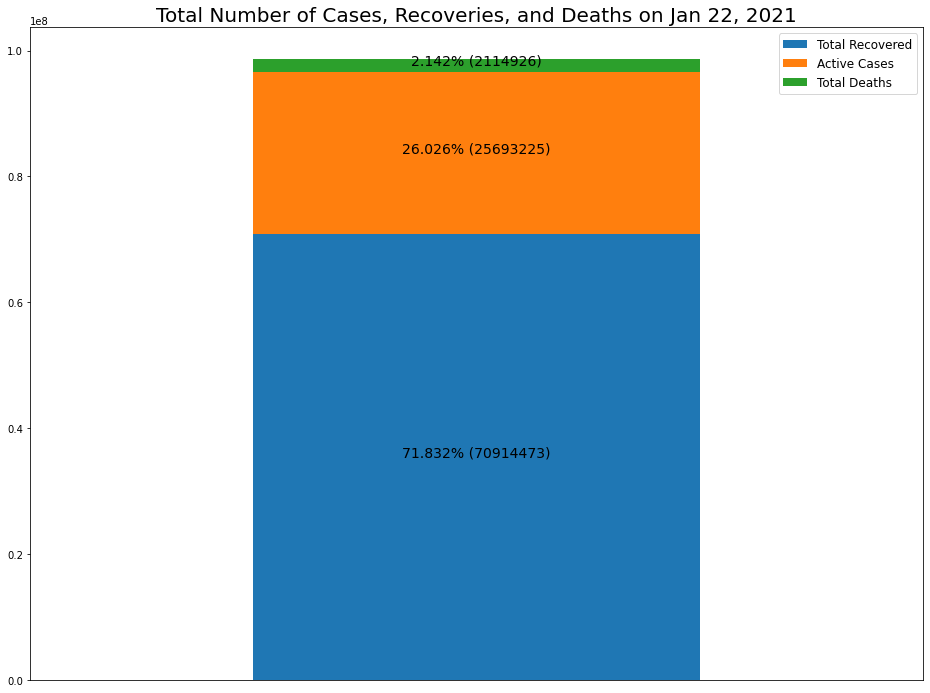

In [15]:
cases_df = df[["Total Recovered", "Active Cases", "Total Deaths"]].loc[0]
pd.DataFrame(cases_df).T.plot.bar(stacked=True, figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"Total Number of Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.legend(prop={"size": 12})

prev = 0
total = cases_df.sum()
for num in cases_df.cumsum():
    val = round((num-prev)/total*100, 3)
    plt.annotate(f"{val}% ({num-prev})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
    prev = num
plt.show()

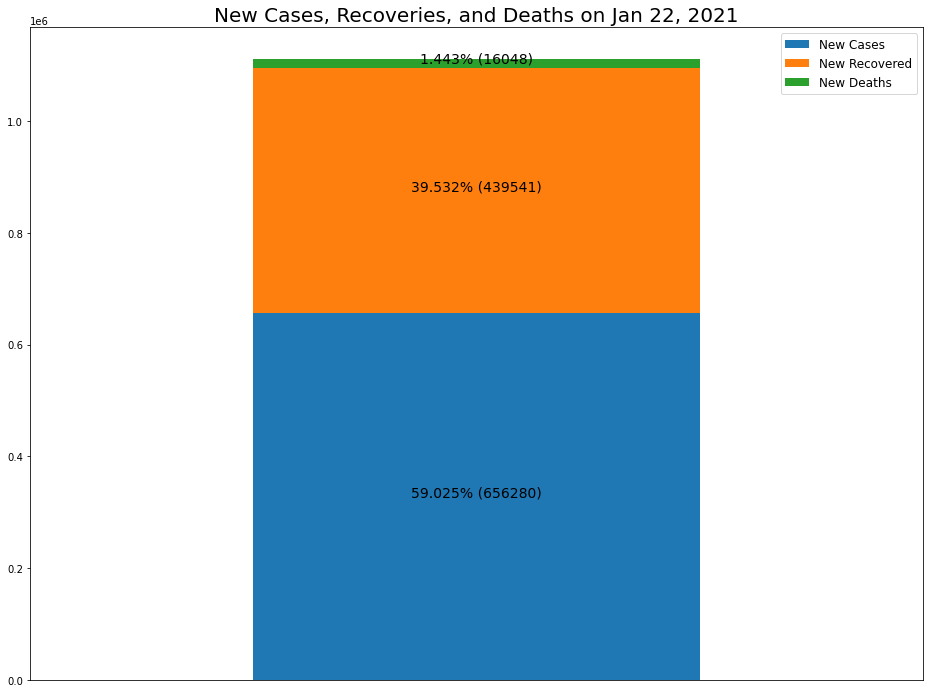

In [16]:
new_df = df[["New Cases", "New Recovered", "New Deaths"]].loc[0]
pd.DataFrame(new_df).T.plot.bar(stacked=True, figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"New Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.legend(prop={"size": 12})

prev = 0
total = new_df.sum()
for num in new_df.cumsum():
    val = round((num-prev)/total*100, 3)
    plt.annotate(f"{val}% ({round(num-prev)})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
    prev = num
plt.show()

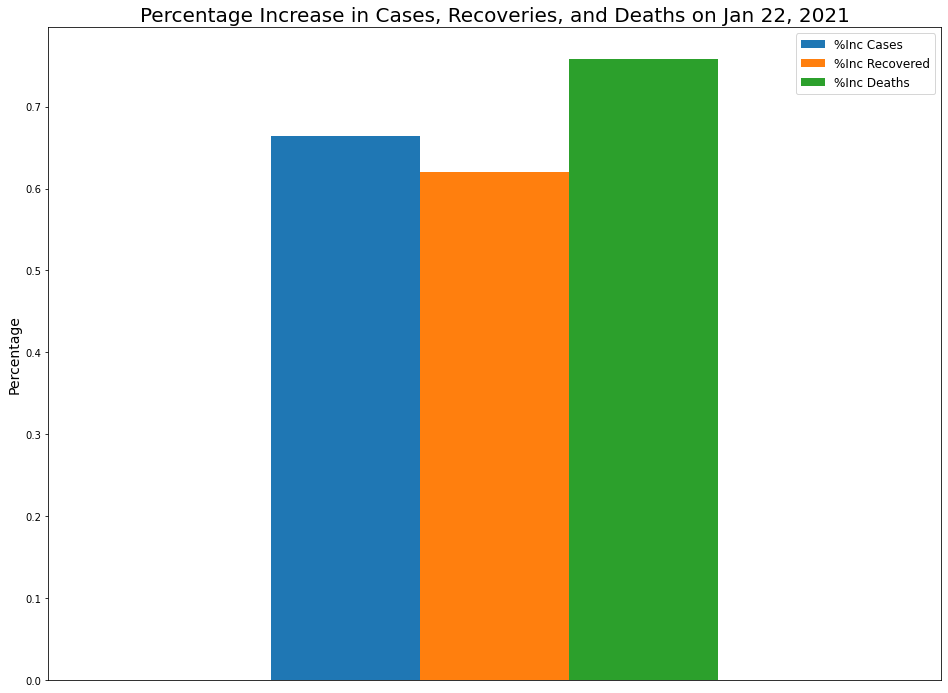

In [17]:
pinc_df = df[["%Inc Cases", "%Inc Recovered", "%Inc Deaths"]].loc[0]
pd.DataFrame(pinc_df).T.plot.bar(figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"Percentage Increase in Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.ylabel("Percentage", fontsize=14)
plt.legend(prop={"size": 12})
plt.show()

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="continent">By Continent<a class="anchor-link" href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#continent">¶</a></h1>

In [18]:
continent_df = df.groupby('Continent').sum().drop('All')
continent_df = continent_df.reset_index()
continent_df

,Continent,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,%Inc Cases,%Inc Deaths,%Inc Recovered
0,Africa,3407171,26271.0,83859,928.0,2851959,30046.0,471353,2643,234811.0,3861.5,28491678,2539513,1358384701,57.993876,-183.624480,44.981205
1,Asia,22327740,75948.0,357698,1016.0,20753758,74475.0,1216281,24011,713958.0,7358.3,372046542,14412393,3172191134,23.690489,110.357216,32.272823
2,Australia/Oceania,49780,42.0,1068,-7.0,33823,12.0,14885,7,65198.0,492.0,14214433,962331,41089700,-107.682770,283.997628,88.097408
3,Europe,28712274,225468.0,657536,5933.0,15624361,139899.0,8420978,29928,2162569.0,40449.0,414629962,39066857,747885039,26.625131,10.189873,33.932100
4,North America,28998533,230664.0,611481,6036.0,18028957,147774.0,10358093,35085,642406.0,9979.0,324669866,11364515,591612015,13.892997,-279.402389,23.284734
5,South America,15124112,97744.0,398531,2055.0,13305479,47245.0,1420101,19452,335461.0,8010.0,62966696,3828727,432750567,9.143478,108.730254,5.886508


In [19]:
cases_vis_list = ['Total Cases', 'Active Cases', 'New Cases', 'Serious/Critical', 'Tot Cases/1M']
deaths_vis_list = ['Total Deaths', 'New Deaths', 'Deaths/1M']
recovered_vis_list = ['Total Recovered', 'New Recovered']
tests_vis_list = ['Total Tests', 'Tests/1M']
essentials = [['Total Cases', 'Active Cases', 'New Cases'], ['Total Deaths', 'New Deaths'], ['Total Recovered', 'New Recovered']]

In [20]:
def continent_visualization(vis_list):
    for label in vis_list:
        pd.DataFrame(continent_df[label]).T.plot.bar(stacked=True, figsize=(16, 12))
        plt.title(f"{label} at the end of {yesterday_str}", fontsize=24)
        plt.xlabel("")
        plt.ylabel(f"{label}", fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(continent_df['Continent'])

        prev = 0
        total = continent_df[label].sum()
        for num in continent_df[label].cumsum():
            val = round((num-prev)/total*100, 3)
            if val < 1:
                continue
            plt.annotate(f"{val}% ({round(num-prev)})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
            prev = num

        plt.show()
        gc.collect()

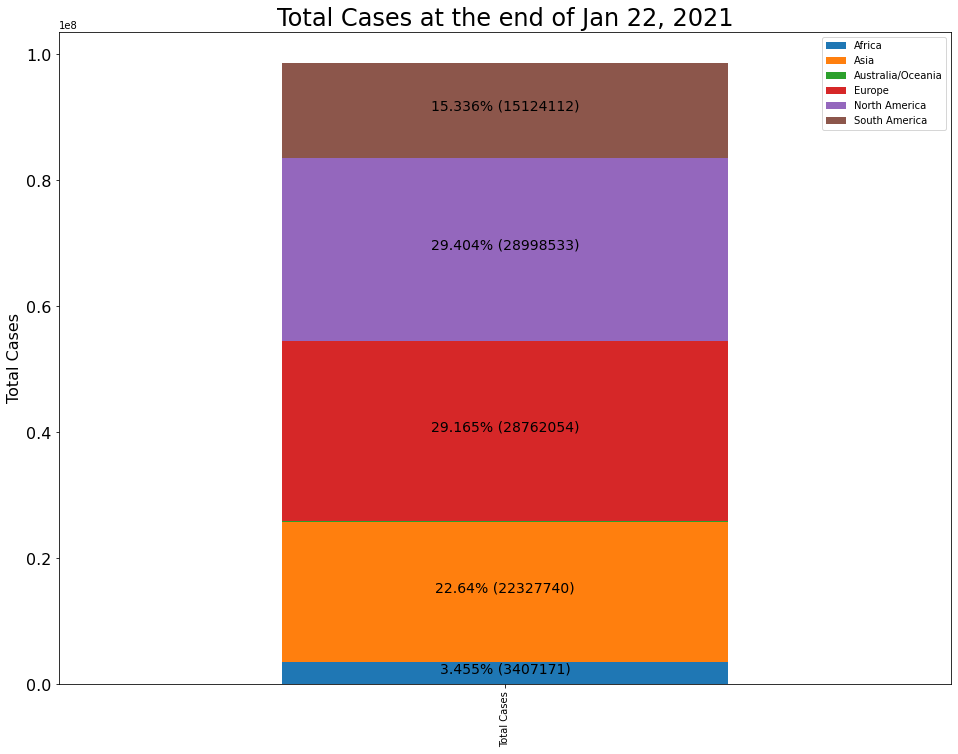

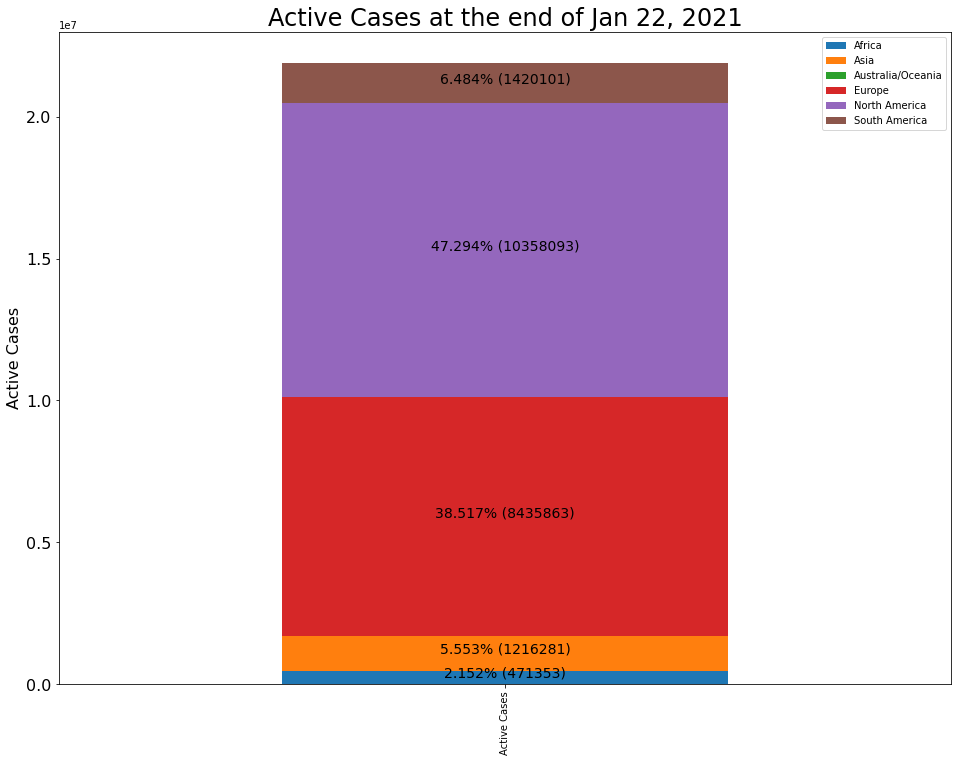

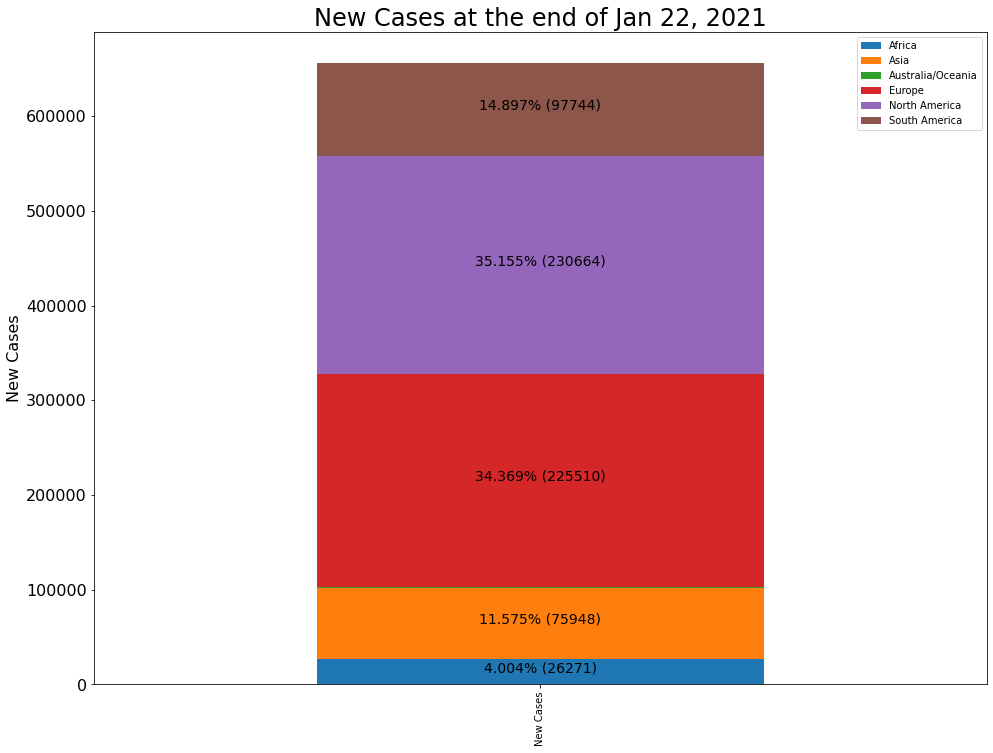

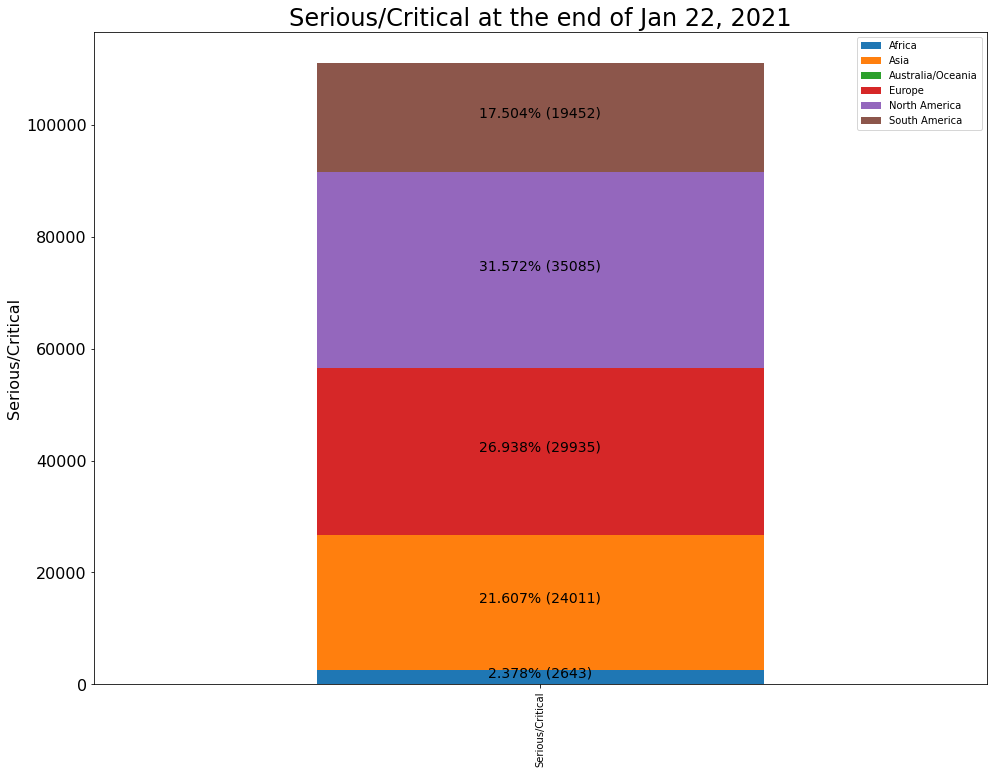

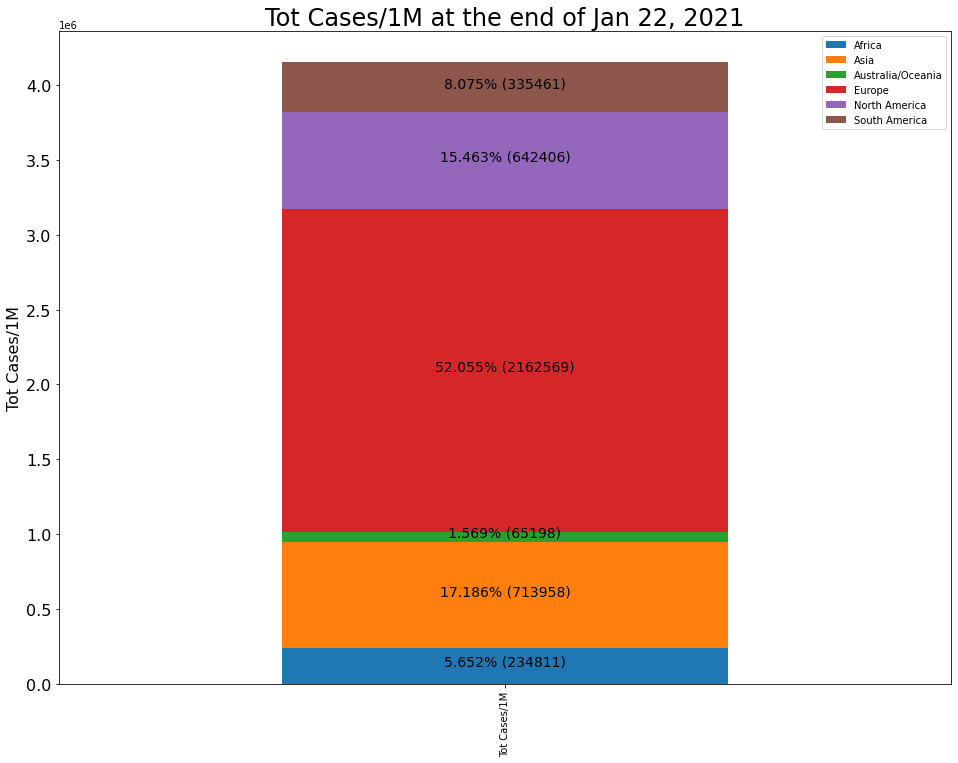

In [21]:
continent_visualization(cases_vis_list)

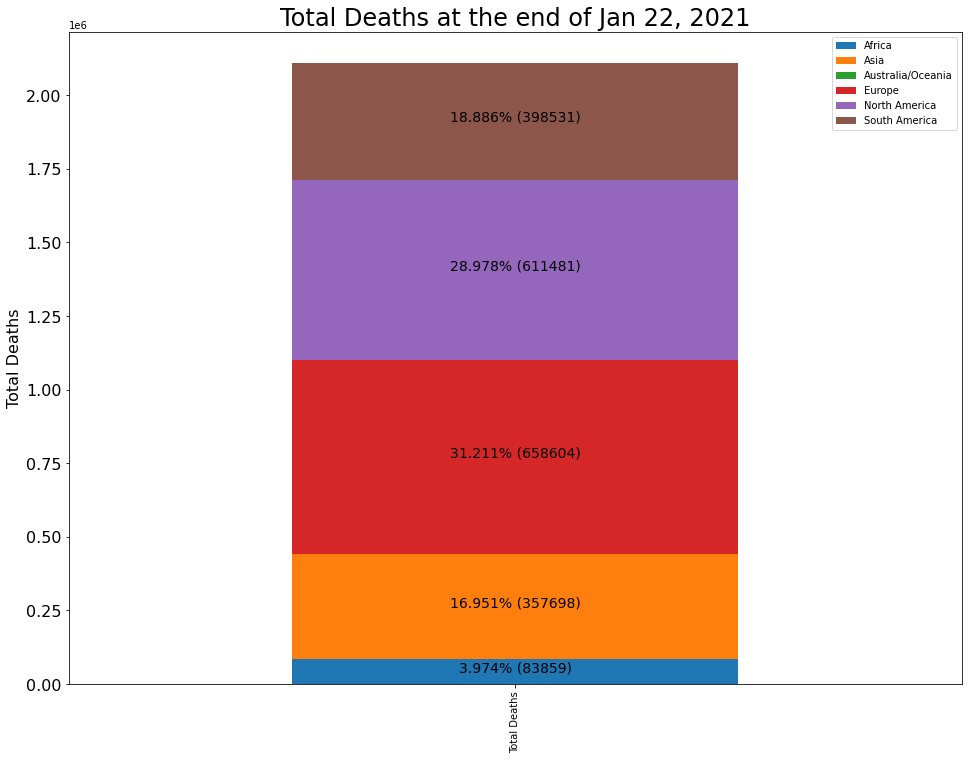

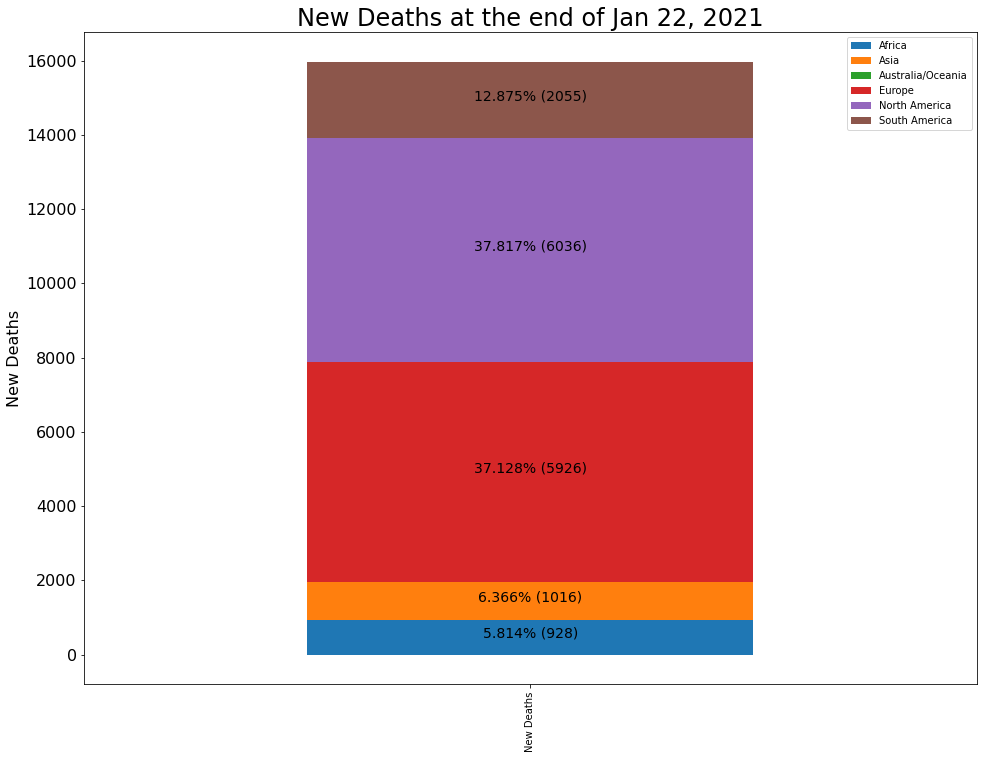

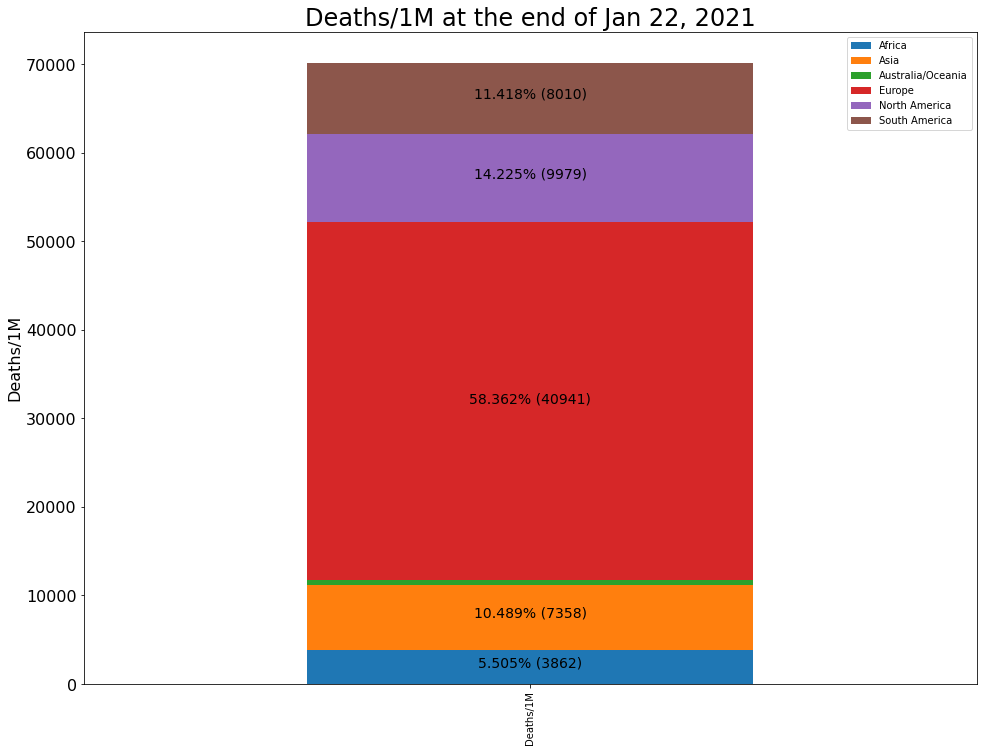

In [22]:
continent_visualization(deaths_vis_list)

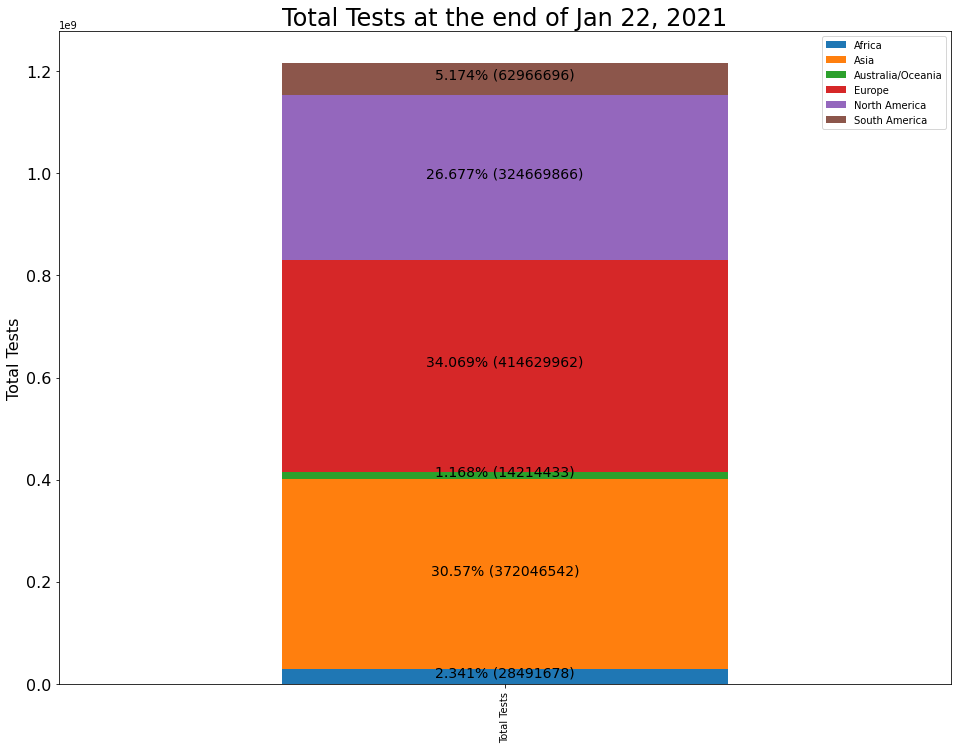

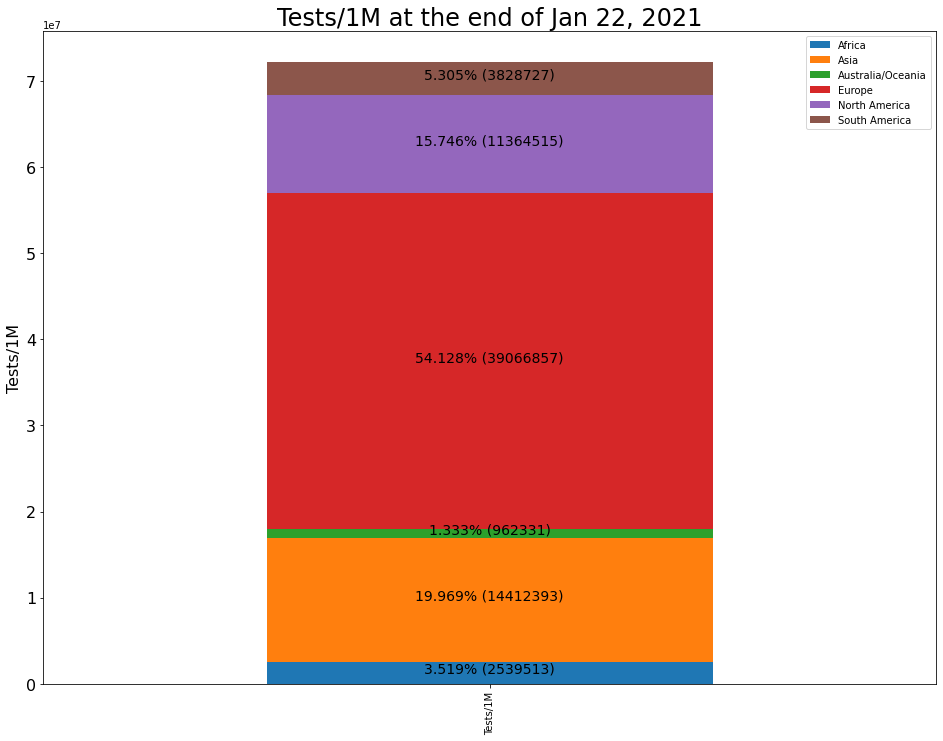

In [23]:
continent_visualization(tests_vis_list)

In [24]:
def continent_visualization2(index, label):
    continent_df.plot.bar(x="Continent", y=essentials[index], stacked=True, figsize=(16, 12))
    plt.title(f"{label} at the end of {yesterday_str}", fontsize=24)
    plt.xlabel("")
    plt.ylabel(f"{label}", fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    gc.collect()

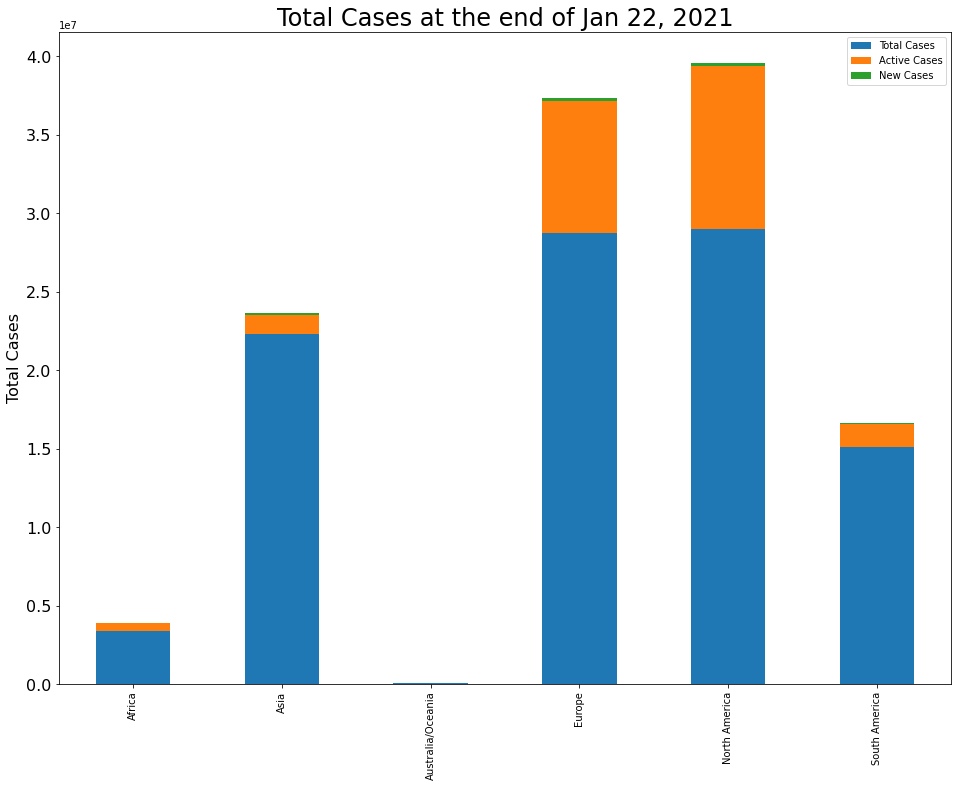

In [25]:
continent_visualization2(0, "Total Cases")

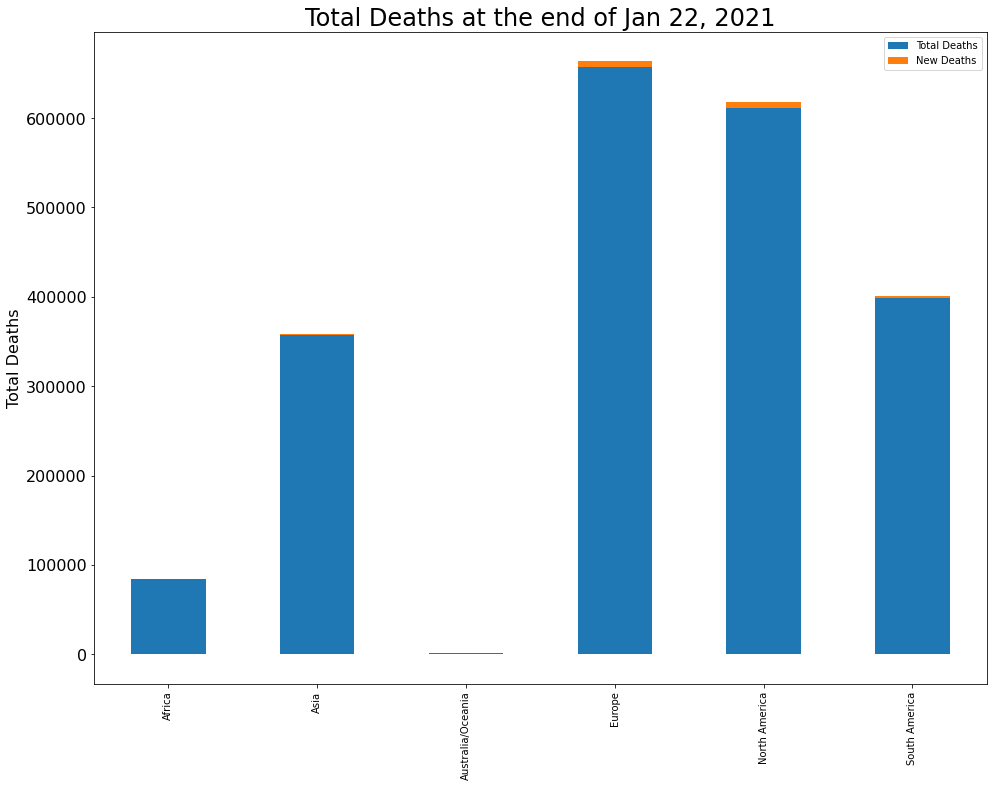

In [26]:
continent_visualization2(1, "Total Deaths")

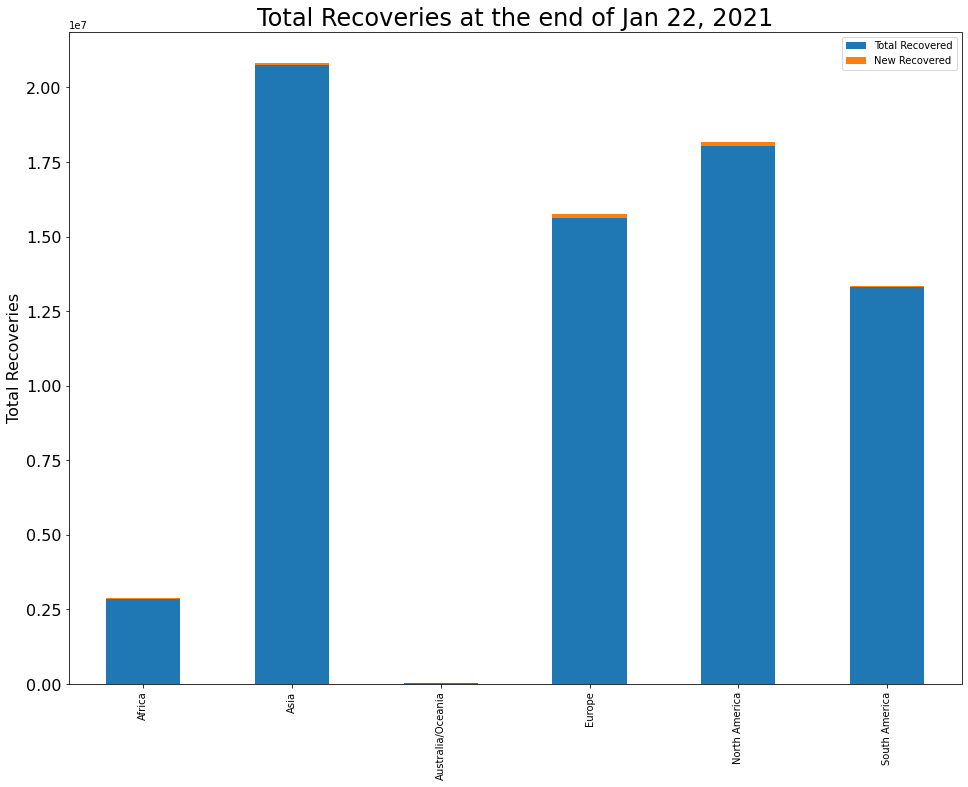

In [27]:
continent_visualization2(2, "Total Recoveries")

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="countries">By Countries<a class="anchor-link" href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#countries">¶</a></h1>

In [28]:
df = df.drop([len(df)-1])
country_df = df.drop([0])

In [29]:
country_l = country_df.columns[1:14]

fig = go.Figure()
c = 0
for i in country_df.index:
    if c<4:
        fig.add_trace(go.Bar(name=country_df['Country'][i], x=country_l, y=country_df.loc[i][1:14]))
    else:
        break
    c += 1
    
fig.update_layout(title={'text': '4 Countries with Most COVID Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", yaxis_type="log", xaxis_tickangle=-90)
fig.show()

In [30]:
inc_l = country_df.columns[15:]
inc_df = country_df.sort_values("%Inc Cases", ascending=False)
fig = go.Figure()
c = 0
for i in inc_df.index:
    if i > 50:
        continue
    if c < 4:
        fig.add_trace(go.Bar(name=country_df['Country'][i], x=inc_l, y=inc_df.loc[i][15:]))
    else:
        break
    c += 1
    
fig.update_layout(title={'text': '4 Countries with Highest Increase in COVID Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", xaxis_tickangle=0)
fig.show()

In [31]:
country_labels = country_df.columns[1:14]

def country_visualization(continent):
    buttons_list = []
    base_list = [False for i in range(len(country_df))]
    for i in range(len(country_df)):
        if country_df['Continent'].iloc[i] != continent:
            continue
        tmp_list = base_list.copy()
        tmp_list[i] = True
        buttons_list.append(dict(
                    args=[{"visible": tmp_list}],
                    label=country_df['Country'].iloc[i],
                    method="update"
                ))


    fig = go.Figure()
    c = 0
    for i in country_df.index:
        if country_df['Continent'][i] != continent:
            continue
        fig.add_trace(go.Bar(name=country_df['Country'][i], x=country_labels, y=country_df.loc[i][1:14], visible=False if c != 0 else True))
        c += 1

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons_list,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    fig.update_layout(title={'text': '%s COVID-19 Cases Search on %s' % (continent, yesterday_str), 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_type="log", xaxis_tickangle=-90)
    fig.show()

<h1 id="country-search">COVID-19 Cases Search</h1>

In [32]:
country_visualization('Africa')

In [33]:
country_visualization('Asia')

In [34]:
country_visualization('Australia/Oceania')

In [35]:
country_visualization('Europe')

In [36]:
country_visualization('North America')

In [37]:
country_visualization('South America')

In [38]:
bar_list = []
for i in country_df.index:
    bar_list.append(go.Bar(name=country_df['Country'][i], y=[country_df['Total Cases'][i]]))
    
fig = go.Figure(data=bar_list)
fig.update_layout(title={'text': 'Stacked Bar Chart of All Countries COVID-19 Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, barmode='stack', height=1200)
fig.show()

In [39]:
bar = go.Bar(x=country_df['Country'], y=country_df['Total Cases'], marker=dict(color=df['Total Cases'], colorscale='Reds', showscale=True))
fig = go.Figure(data=[bar])
fig.update_layout(title={'text': 'Number of COVID Cases by Country on %s, log scale' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_type="log", xaxis_tickangle=-90)

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px"> Statistical Analysis </h1>

This section is a WIP, I would appreciate any suggestions for this section.

# Concluding Remarks

If you've read down this far in the notebook, thank you so much. This notebook took quite a long time to make, but that's aside from the point - these visualizations are for the community, and I'd like this project to also be for the community. So please leave an upvote - it takes literally less than a second - so this notebook/project gains more traction & recognition.

And, like I said earlier, if you have any suggestions or code for other visualizations, please let me know in the comments or in DMs. I know I'm not the greatest coder, so everything/anything is appreciated.

Stay safe, stay healthy, educate yourself. Thanks!